# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [BLANQUART Ekhi](https://github.com/azagal952)
- [DENISSELLE Alexis](https://github.com/AlexisDns23)

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [2]:
%load_ext autoreload
%autoreload 2

%load_ext Cython

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from numba import jit

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

In [4]:
# load the training set
train = np.loadtxt('data/synth_train.txt')
class_train = train[:, 0].astype(int) # labels of the train set
class_train_1 = train[train[:, 0] == 1]
class_train_2 = train[train[:, 0] == 2]
x_train = train[:, 1:]

# load the test set
test = np.loadtxt('data/synth_test.txt')
class_test = test[:, 0].astype(int)
class_test_1 = test[test[:, 0] == 1]
class_test_2 = test[test[:, 0] == 2]
x_test = test[:, 1:]

N_train = train.shape[0]
N_test = test.shape[0]

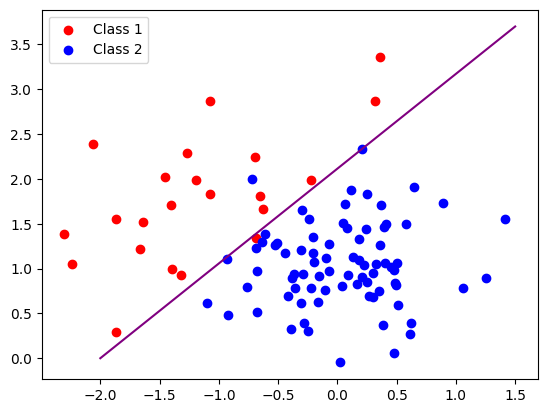

In [5]:
plt.scatter(class_train_1[:, 1], class_train_1[:, 2], color='red',  label='Class 1')
plt.scatter(class_train_2[:, 1], class_train_2[:, 2], color='blue', label='Class 2')
x=np.array([[-2,0],[1.5,3.7]])
plt.plot(x[:,0],x[:,1], '-', color='purple')
plt.legend(loc = 'best')
plt.show()

We distinguished the two classes by using some colors for the scatter plots. We also plotted the frontier that we roughly see to the eye, in purple.

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).

**Answer:**

In [6]:
def KNN_algorithm(x_train, class_train, x_test, k):
    """Perform the K-nearest neighbours algorithm for classification

    Args:
        x_train (np.ndarray): matrix of coordinates of the train set
        class_train (np.ndarray): labels of points in train set
        x_test (np.ndarray): matrix of coordinates of the test set
        k (int): Number of nearest neighbours to consider

    Returns:
        np.ndarray: predicted labels for x_test
    """
    class_test_pred = np.zeros(x_test.shape[0], dtype=class_train.dtype)

    for i, test_point in enumerate(x_test):
        ## For each point of the test set, we compute the distance between each point of x_train and this test point.
        distances = np.linalg.norm(x_train - test_point, axis=1)

        ## We select indexes of the k points of x_train for which the distance with the point of x_test is minimal
        nearest_neighbor_ids = np.argsort(distances)[:k]

        nearest_neighbor_labels = class_train[nearest_neighbor_ids]
        class_test_pred[i] = np.bincount(nearest_neighbor_labels).argmax()

    return class_test_pred

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

Error rate for 1-NN algorithm is:0.065
Error rate for 2-NN algorithm is:0.06
Error rate for 3-NN algorithm is:0.045
Error rate for 4-NN algorithm is:0.05
Error rate for 5-NN algorithm is:0.06
Error rate for 6-NN algorithm is:0.055
Error rate for 7-NN algorithm is:0.07
Error rate for 8-NN algorithm is:0.07
Error rate for 9-NN algorithm is:0.075
Error rate for 10-NN algorithm is:0.075
Error rate for 11-NN algorithm is:0.09
Error rate for 12-NN algorithm is:0.075
Error rate for 13-NN algorithm is:0.08
Error rate for 14-NN algorithm is:0.075
Error rate for 15-NN algorithm is:0.075
Error rate for 16-NN algorithm is:0.075
Error rate for 17-NN algorithm is:0.08
Error rate for 18-NN algorithm is:0.08
Error rate for 19-NN algorithm is:0.08
Error rate for 20-NN algorithm is:0.08


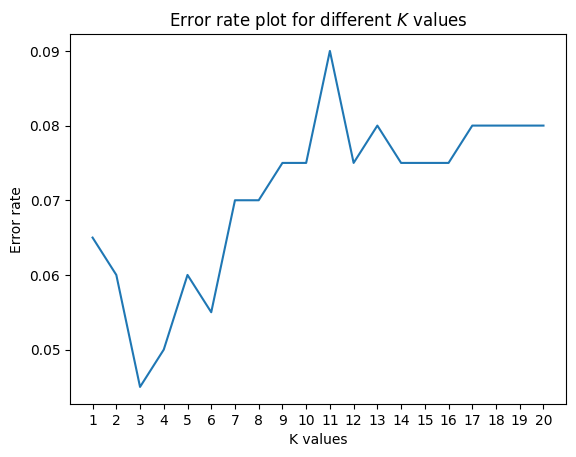

In [9]:
error_rate = np.zeros(20)
for k in range (1,21):
    class_test_pred=KNN_algorithm(x_train, class_train, x_test, k)
    sum=np.sum(class_test_pred!=class_test)
    error_rate[k - 1] = sum/N_test
    print(f"Error rate for {k}-NN algorithm is:{error_rate[k - 1]}")

plt.plot(np.arange(1,21),error_rate)
plt.xticks(range(1,21))
plt.xlabel('K values')
plt.ylabel("Error rate")
plt.title("Error rate plot for different $K$ values")
plt.show()

The error rate is at its minimum for $K = 3$. Therefore, we plotted the results for this $K$ value.

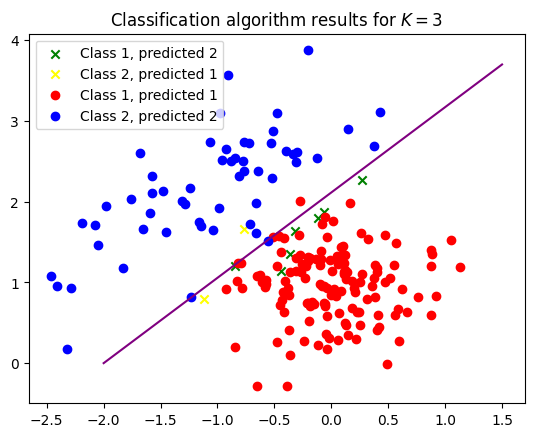

In [10]:
class_test_pred=KNN_algorithm(x_train, class_train, x_test, 3)

false_positive = test[(test[:, 0] == 1) & (class_test_pred == 2)]
false_negative = test[(test[:, 0] == 2) & (class_test_pred == 1)]
true_positive  = test[(test[:, 0] == 2) & (class_test_pred == 2)]
true_negative  = test[(test[:, 0] == 1) & (class_test_pred == 1)]


plt.scatter(false_positive[:, 1], false_positive[:, 2], color='green', marker='x',  label='Class 1, predicted 2')
plt.scatter(false_negative[:, 1], false_negative[:, 2], color='yellow', marker='x', label='Class 2, predicted 1')
plt.scatter(true_positive[:, 1], true_positive[:, 2], color='red',  label='Class 1, predicted 1')
plt.scatter(true_negative[:, 1], true_negative[:, 2], color='blue', label='Class 2, predicted 2')
x=np.array([[-2,0],[1.5,3.7]])
plt.plot(x[:,0],x[:,1], '-', color='purple')
plt.legend(loc = 'best')
plt.title("Classification algorithm results for $K = 3$")
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

We still have our guessed frontier in purple. The crosses represent the errors, and we coloured them for the different categories (false positive and false negative).

As previously said, the error rate is minimal for $K=3$. We observe that the errors of prediction are mostly made around the decision boundary. It is logical, as this is where this is the harder to 'understand' how is shaped the real frontier. In a classification context, $K$ acts as a parameter of regularization (for $K=1$, the frontier is rough, and for a big $K$, it is smooth).

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [11]:
# Predictions using sklearn KNeighborsClassifier
knn_sklearn = KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(x_train, class_train)
class_test_pred_sklearn = knn_sklearn.predict(x_test)

print(f"Custom KNN predictions: {class_test_pred}")
print(f"Sklearn KNN predictions: {class_test_pred_sklearn}")

Custom KNN predictions: [2 2 2 2 2 2 2 2 2 1 2 1 1 2 1 2 2 1 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 1 2 2 1
 1 2 2 1 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2
 1 1 2 2 1 1 1 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 1 1 2 2 2
 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 1
 2 2 1 1 2 1 1 1 2 2 2 2 2 2 1]
Sklearn KNN predictions: [2 2 2 2 2 2 2 2 2 1 2 1 1 2 1 2 2 1 1 2 2 1 2 1 2 2 1 2 2 1 2 1 2 1 2 2 1
 1 2 2 1 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2
 1 1 2 2 1 1 1 2 1 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 1 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 1 1 2 2 2
 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 1
 2 2 1 1 2 1 1 1 2 2 2 2 2 2 1]


In [12]:
%%timeit
knn_sklearn = KNeighborsClassifier(n_neighbors=3)
knn_sklearn.fit(x_train, class_train)
knn_sklearn.predict(x_test)


9.9 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
KNN_algorithm(x_train, class_train, x_test, 3)

2.98 ms ± 37.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Our customized version seems to be faster than the scikit-learn's KNN. However, our dataset only contains 100 observations, which is quite small. The scikit-learn's KNN should be faster on larger datasets.

### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

In [11]:
# load the data
data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
attributes = data[:,2:]
labels = data[:,1]

x_train, x_test, class_train, class_test = train_test_split(attributes, labels, random_state=42)
class_train = class_train.astype(int)
class_test = class_test.astype(int)

N_train = x_train.shape[0]
N_test = x_test.shape[0]

Error rate for 1-NN algorithm is:0.0699
Error rate for 2-NN algorithm is:0.0769
Error rate for 3-NN algorithm is:0.0699
Error rate for 4-NN algorithm is:0.0559
Error rate for 5-NN algorithm is:0.0350
Error rate for 6-NN algorithm is:0.0490
Error rate for 7-NN algorithm is:0.0420
Error rate for 8-NN algorithm is:0.0420
Error rate for 9-NN algorithm is:0.0420
Error rate for 10-NN algorithm is:0.0280
Error rate for 11-NN algorithm is:0.0210
Error rate for 12-NN algorithm is:0.0210
Error rate for 13-NN algorithm is:0.0280
Error rate for 14-NN algorithm is:0.0280
Error rate for 15-NN algorithm is:0.0350
Error rate for 16-NN algorithm is:0.0350
Error rate for 17-NN algorithm is:0.0350
Error rate for 18-NN algorithm is:0.0280
Error rate for 19-NN algorithm is:0.0350
Error rate for 20-NN algorithm is:0.0350


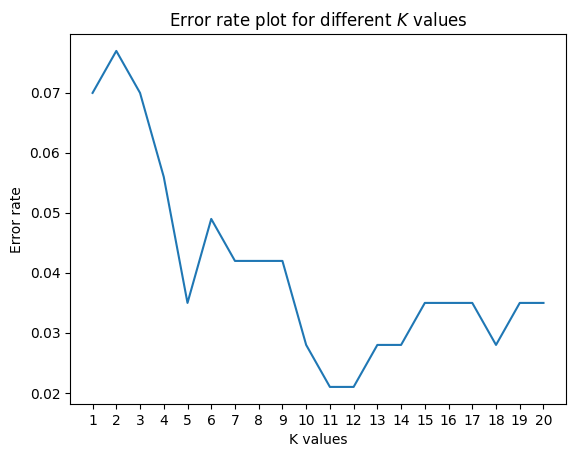

In [12]:
error_rate = np.zeros(20)
for k in range (1,21):
    class_test_pred=KNN_algorithm(x_train, class_train, x_test, k)
    sum=np.sum(class_test_pred!=class_test)
    error_rate[k - 1] = sum/N_test
    print(f"Error rate for {k}-NN algorithm is:{error_rate[k - 1]:.4f}")
plt.plot(np.arange(1,21),error_rate)
plt.xticks(range(1,21))
plt.xlabel('K values')
plt.ylabel("Error rate")
plt.title("Error rate plot for different $K$ values")
plt.show()

In [13]:
%%timeit

KNN_algorithm(x_train, class_train, x_test, 11)

8.37 ms ± 228 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit

knn_sklearn = KNeighborsClassifier(n_neighbors = 11)
knn_sklearn.fit(x_train, class_train)
knn_sklearn.predict(x_test)

7.99 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected and mentioned in the previous question, the scikit-learn's algorithm is faster than ours when there is more data to analyze.

To represent the errors here, as we cannot plot them in 2D, we chose to show the confusion matrix, which put the classifications in 4 different categories: true positive, false positive, true negative and false negative.

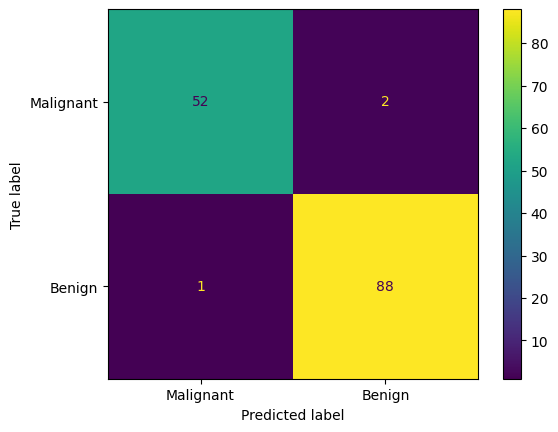

In [18]:
knn_sklearn = KNeighborsClassifier(n_neighbors=11)
knn_sklearn.fit(x_train, class_train)
class_test_pred = knn_sklearn.predict(x_test)

confusion_matrix = confusion_matrix(class_test, class_test_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels= ['Malignant', 'Benign'])
cm_display.plot()
plt.show()

In [19]:
class_test_pred

array([2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2])

There are 3 classification errors (2 false negative and 1 false positive), which corresponds to a 2.1% relative error on the test set. For this topic, the prediction of breast cancer, this is an acceptable rate of error.

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [2]:
!cd example_cy && python setup.py build_ext --inplace

In [3]:
import example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

For the compilation to work, we had to delete the given `__init__.py` file, otherwise the compiler gave us an error telling us it couldn't create the file in the selected folder.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [1]:
!cd example_np_cy && python setup.py build_ext --inplace

In [4]:
array_1 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
array_2 = np.random.uniform(0, 1000, size=(3000, 2000)).astype(np.intc)
a = 4
b = 3
c = 9

In [8]:
def compute_np(array_1, array_2, a, b, c):
    return np.clip(array_1, 2, 10) * a + array_2 * b + c

In [9]:
%%timeit

compute_np(array_1, array_2, a, b, c)

58.3 ms ± 8.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
import example_np_cy.compute as compute_py
import example_np_cy.compute_cy as compute_cy

In [17]:
%%timeit

compute_py.compute(array_1, array_2, a, b, c)

6.01 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit -r 7 -n 100

compute_cy.compute(array_1, array_2, a, b, c)

26.8 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


When adding types and using memviews, I obtain a code that computes in 43.6ms, whereas the NumPy one computes in 58.3ms. Therefore, it is already faster, as mentioned in the tutorial.

When I stop bound checking and verifying that negative indices are not used, the cython function computes in 23.5ms, which is twice faster than in the previous case!

When using C-contiguous memory views, the cython function computes in 16.8ms! It is quite the same when inferring types, which is logical.

In [8]:
compute_cy.compute(array_1, array_2, a, b, c).dtype

dtype('int32')

In [10]:
compute_cy.compute(array_1.astype(np.double), array_2.astype(np.double), a, b, c).dtype

dtype('float64')

3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [1]:
!cd knn && python setup.py build_ext --inplace

Compiling knn_several_types.pyx because it changed.
[1/1] Cythonizing knn_several_types.pyx
knn_several_types.c
knn_several_types.c(24049): warning C4244: '='ÿ: conversion de '__int64' en 'double', perte possible de donn‚es
knn_several_types.c(24766): warning C4244: '='ÿ: conversion de '__int64' en 'double', perte possible de donn‚es
knn_several_types.c(25482): warning C4244: '='ÿ: conversion de '__int64' en 'double', perte possible de donn‚es
   Cr‚ation de la bibliothŠque build\temp.win-amd64-cpython-311\Release\knn_several_types.cp311-win_amd64.lib et de l'objet build\temp.win-amd64-cpython-311\Release\knn_several_types.cp311-win_amd64.exp
G‚n‚ration de code en cours
Fin de la g‚n‚ration du code


4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

data = np.loadtxt('data/wdbc12.data.txt', delimiter=',')
attributes = data[:,2:]
labels = data[:,1]

x_train, x_test, class_train, class_test = train_test_split(attributes, labels, random_state=42)
class_train = class_train.astype(int)
class_test = class_test.astype(int)
x_train = x_train.astype(float)
x_test = x_test.astype(float)

N_train = x_train.shape[0]
N_test = x_test.shape[0]

In [3]:
import knn.knn_pure_python as knn_pure_python
import knn.knn_typed as knn_typed
import knn.knn_memview as knn_memview
import knn.knn_contiguous as knn_contiguous
import knn.knn_infer_types as knn_infer_types
import knn.knn_tuning_indexing as knn_tuning_indexing
import knn.knn_several_types as knn_several_types

knn_typed.KNN_algorithm(x_train, class_train, x_test, 11)
knn_memview.KNN_algorithm(x_train, class_train, x_test, 11)
knn_contiguous.KNN_algorithm(x_train, class_train, x_test, 11)
knn_infer_types.KNN_algorithm(x_train, class_train, x_test, 11)
knn_tuning_indexing.KNN_algorithm(x_train, class_train, x_test, 11)
knn_several_types.KNN_algorithm(x_train, class_train, x_test, 11)

array([2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2])

In [6]:
%%timeit
## WARNING: it's numpy, not Python
knn_pure_python.KNN_algorithm(x_train, class_train, x_test, 11)

7.64 ms ± 789 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Even though we called the file 'pure python', this version uses a lot of NumPy vectorization possibilities. Therefore, this version is the NumPy one, and is already very fast. With C, we will try to go faster than the Numpy one.

In [7]:
%%timeit

knn_typed.KNN_algorithm(x_train, class_train, x_test, 11)

470 ms ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit

knn_memview.KNN_algorithm(x_train, class_train, x_test, 11)

7.32 ms ± 336 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit

knn_contiguous.KNN_algorithm(x_train, class_train, x_test, 11)

7.83 ms ± 610 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit

knn_infer_types.KNN_algorithm(x_train, class_train, x_test, 11)

7.8 ms ± 525 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%%timeit

knn_tuning_indexing.KNN_algorithm(x_train, class_train, x_test, 11)

4.03 ms ± 487 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit

knn_several_types.KNN_algorithm(x_train, class_train, x_test, 11)

4.2 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


When finished, the function computes in roughly 4ms, which is very faster, and about as twice faster as the version with NumPy!

## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

As Numba, with nopython, cannot comprehend np.diff, we decided to compute the differences by hand.

In [34]:
@jit
def gradient2D_numba(X):
    XD_h = np.zeros_like(X)
    XD_v = np.zeros_like(X)
    
    N,M = X.shape

    for i in range(N):
        for j in range(M - 1):
            XD_h[i, j] = X[i, j + 1] - X[i, j]
        XD_h[i, -1] = 0
    
    for i in range(N - 1):
        for j in range(M):
            XD_v[i, j] = X[i + 1, j] - X[i, j]
    XD_v[-1, :] = 0

    return XD_h, XD_v


@jit
def tv_numba(X):
    """Compute discrete isotropic total variation (TV) of a matrix X

    Args:
        X (np.ndarray): an input matrix

    Returns:
        float: the TV of X
    """
    XDh, XDv=gradient2D_numba(X)

    return np.sum(np.sqrt(XDh**2+XDv**2))

In [39]:
rng = np.random.default_rng(106620185328035836413676238315917800117)
X = rng.random((100, 100))

In [41]:
%%timeit -n 10000

tv_numba(X)

39.9 μs ± 2.41 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [42]:
def gradient2D(X):
    ## NB : the documentation is made in Q3
    if X.ndim != 2: raise ValueError("Input array must be 2-dimensional.")

    XD_h = np.diff(X, axis=1, append=X[:, -1:]) # append last column for boundary
    XD_v = np.diff(X, axis=0, append=X[-1:, :]) # append last line for boundary

    return XD_h, XD_v

def tv(X):
    """Compute discrete isotropic total variation (TV) of a matrix X

    Args:
        X (np.ndarray): an input matrix

    Returns:
        float: the TV of X
    """
    XDh, XDv=gradient2D(X)

    return np.sum(np.sqrt(XDh**2+XDv**2))

In [43]:
%%timeit -n 10000

tv(X)

104 μs ± 40.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


As expected, the numba version is faster than our NumPy version (40μs v. 100μs). Still, both versions are very fast. The acceleration using numba is faster than using cython, but there is less modularity.